<a href="https://colab.research.google.com/github/pjprathmesh/Face-Reconstruct-2.0/blob/master/face_reconstruct_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Aug  9 12:18:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 
import zipfile
 
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")
import os
root = 'data_faces/img_align_celeba'
# img_list = os.listdir(root)
for i in os.listdir(root):
  print(i)
  break

--2020-08-09 12:18:21--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.136
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  73.9MB/s    in 18s     

2020-08-09 12:18:38 (78.1 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]

052163.jpg


In [ ]:

import os
total=os.listdir('data_faces/img_align_celeba')

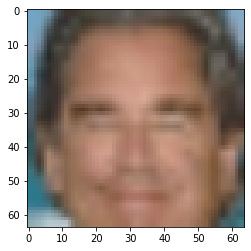

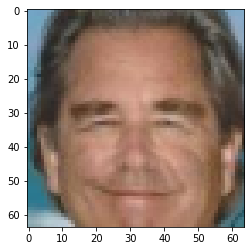

In [ ]:

import os
import cv2
import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization,Input,concatenate,MaxPooling2D,GlobalAveragePooling2D,LeakyReLU,Reshape,Conv2DTranspose,LocallyConnected2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Activation,Lambda
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.losses import categorical_crossentropy,binary_crossentropy
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input
import keras.backend as K
from tensorflow.keras.models import Model   
import matplotlib.pyplot as plt
def gen(index,BS,flag,seed):
  
  root = 'data_faces/img_align_celeba'
  img_batch_positive=np.zeros((BS,64,64,3),np.float32)
  img_batch_anchor=np.zeros((BS,64*64*3),np.float32)
  crop_size = 130
  offset_height = (218 - crop_size) // 2
  offset_width = (178 - crop_size) // 2
 
 
  batchh=0
  for e,i in enumerate(os.listdir(root)):
 
    e=e+index
    if batchh==BS:
        break
 
    
      
   
  
    
    first_positive22=cv2.imread("data_faces/img_align_celeba/"+total[e],1).reshape(218,178,3)
    first_positive22=first_positive22[offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]
 
    first_positive2=cv2.resize(first_positive22,(64,64)).reshape(64,64,3)
 
    
    resized=cv2.resize(first_positive2,(25,25))
    resized2=cv2.resize(resized,(64,64)).reshape(64,64,3)

    noise=tf.random.normal(shape=(64,64,3))
    img_batch_positive[batchh]= resized2/255.#+noise/9
    img_batch_anchor[batchh]=first_positive2.reshape(64*64*3)/255.
 
    batchh+=1
    
    
   
 
  yield e,[img_batch_positive,img_batch_anchor]
 
batch_sub=list(gen(1000,50,"train",1))
 
a=batch_sub[0][1][0][40]
a=cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
b=batch_sub[0][1][1][40].reshape(64,64,3)
b=cv2.cvtColor(b, cv2.COLOR_BGR2RGB)
 
plt.imshow(a)
plt.show()
plt.imshow(b)
# batch_sub[0][0]

In [ ]:
inp=Input((64,64,3))
x=LocallyConnected2D(32,(5,5),activation="relu",kernel_regularizer=keras.regularizers.L2(0.01))(inp)
x=MaxPooling2D(strides=(2,2))(x)
x=Dropout(0.2)(x)

x=LocallyConnected2D(32,(5,5),activation="relu",kernel_regularizer=keras.regularizers.L2(0.01))(x)
x=MaxPooling2D(strides=(2,2))(x)
x=Dropout(0.1)(x)

# x=LocallyConnected2D(32,(5,5),activation="relu")(x)
# x=MaxPooling2D(strides=(2,2))(x)
# x=Dropout(0.5)(x)

x=Flatten()(x)
x=Dense(64*64*3,"sigmoid",kernel_regularizer=keras.regularizers.L2(0.01))(x)

recon=Model(inp,x)
recon.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
locally_connected2d (Locally (None, 60, 60, 32)        8755200   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 32)        0         
_________________________________________________________________
locally_connected2d_1 (Local (None, 26, 26, 32)        17327232  
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)       

0 gen_loss= 70.513504
64 gen_loss= 559.8189
128 gen_loss= 141.73796
192 gen_loss= 248.02493
256 gen_loss= 246.9036
320 gen_loss= 150.0689
384 gen_loss= 120.40483
448 gen_loss= 124.06999
512 gen_loss= 147.01822
576 gen_loss= 131.44058
640 gen_loss= 112.98456
704 gen_loss= 103.90819
768 gen_loss= 106.58125
832 gen_loss= 104.48563
896 gen_loss= 92.55914
960 gen_loss= 83.996826
1024 gen_loss= 89.52493
1088 gen_loss= 97.11359
1152 gen_loss= 87.66034
1216 gen_loss= 84.47295
1280 gen_loss= 93.936646
1344 gen_loss= 84.10659
1408 gen_loss= 82.626305
1472 gen_loss= 74.876205
1536 gen_loss= 79.20528
1600 gen_loss= 75.427605
1664 gen_loss= 84.15445
1728 gen_loss= 80.65595
1792 gen_loss= 73.58057
1856 gen_loss= 74.52963
1920 gen_loss= 75.96974
1984 gen_loss= 73.466125
2048 gen_loss= 67.19408
2112 gen_loss= 66.464294
2176 gen_loss= 67.08033
2240 gen_loss= 72.01814
2304 gen_loss= 70.023056
2368 gen_loss= 69.890686
2432 gen_loss= 65.48062
2496 gen_loss= 67.74057
2560 gen_loss= 71.23838
2624 gen_loss= 

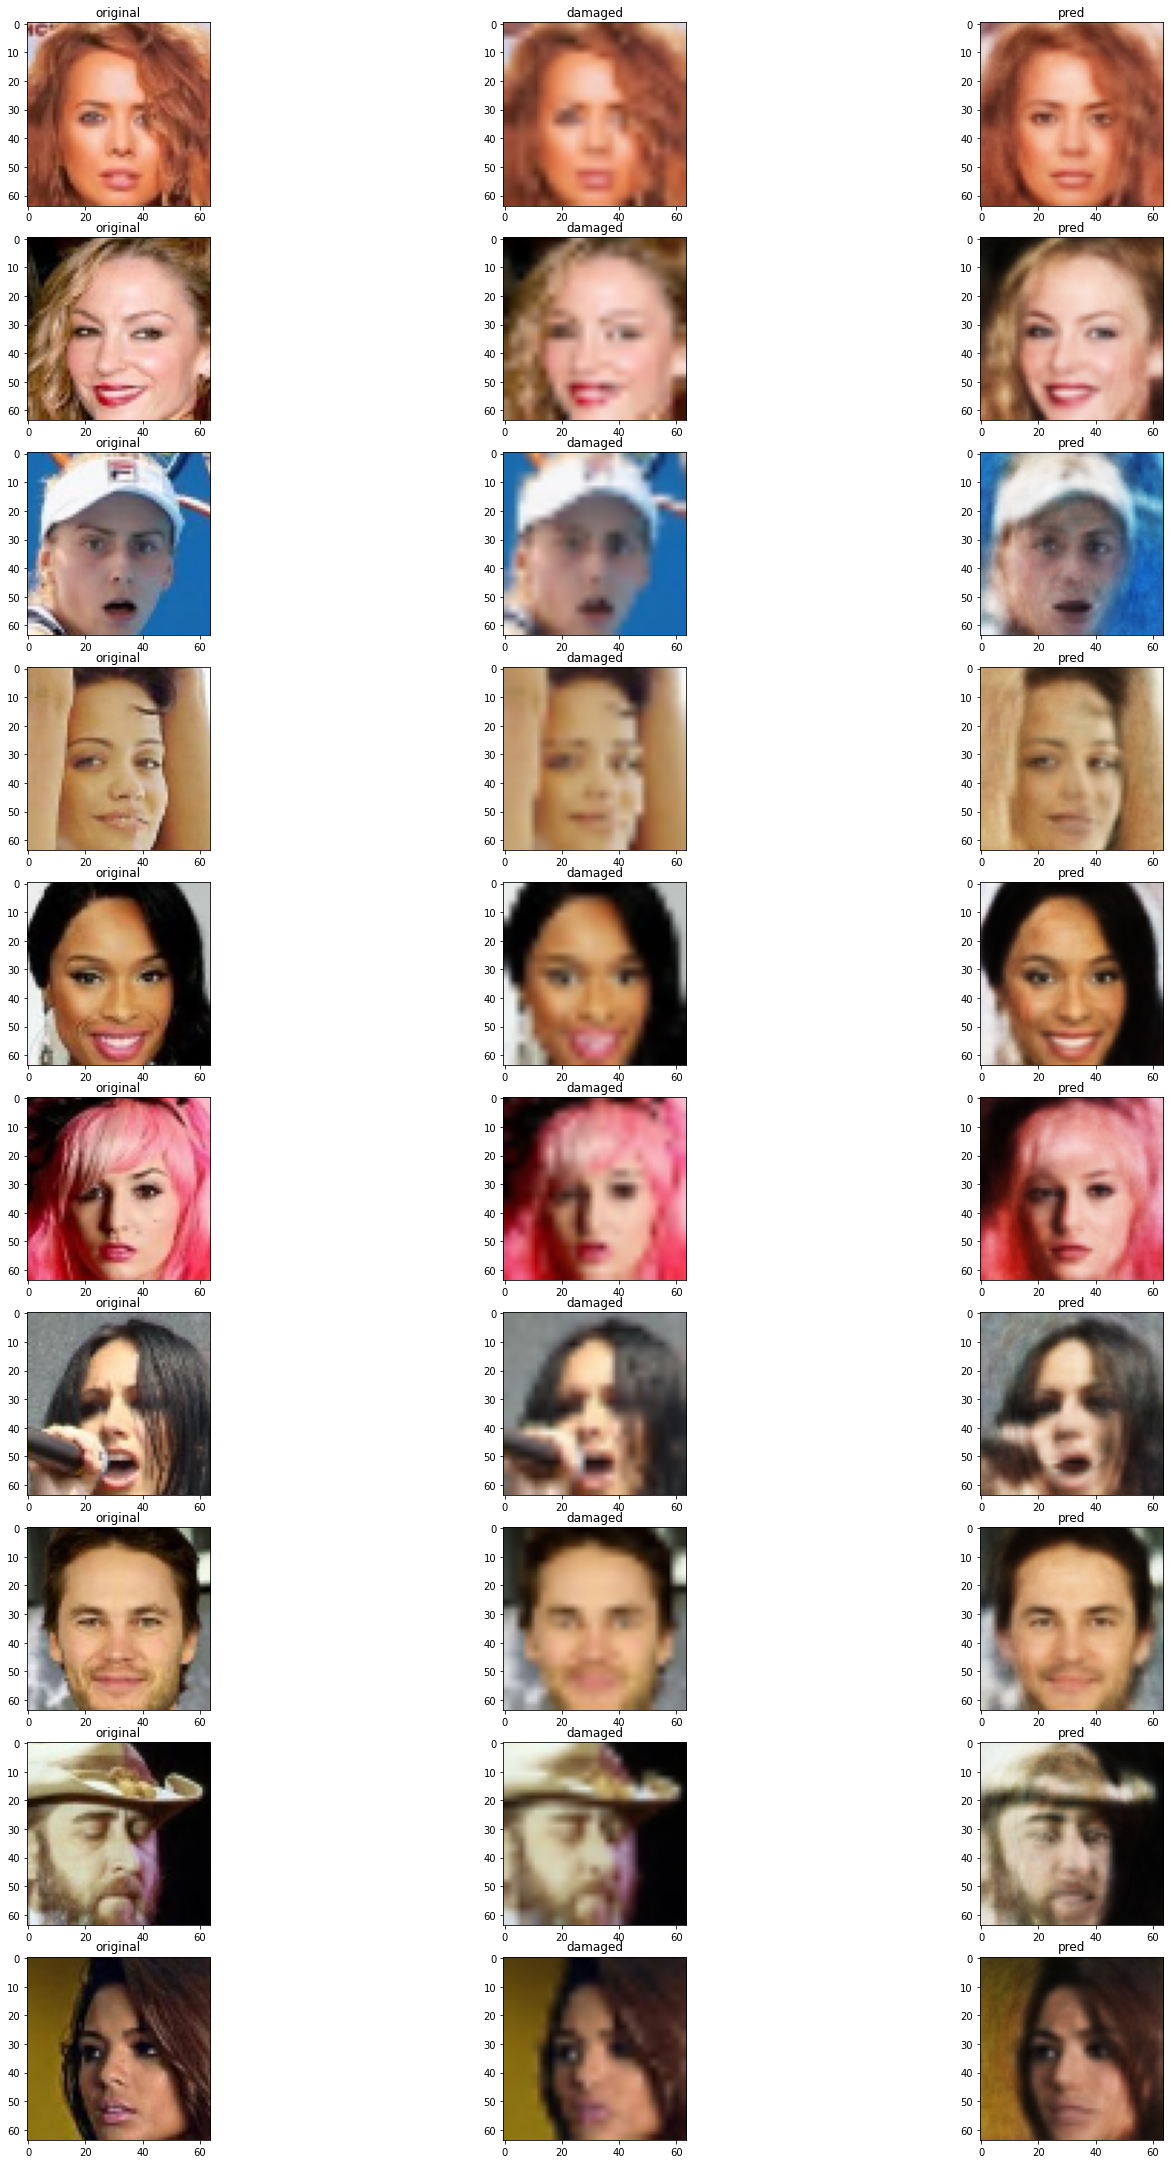

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model
# cross_entropy = BinaryCrossentropy(from_logits=True)


optimizer = tf.keras.optimizers.Adam(0.001)
recon=load_model("/content/drive/My Drive/face_reconstruct_v2.h5")
batch=64
epoch=1
for j in range(epoch):
  ins=0
  see=0
  while True:
    #if ins>202599:
    if ins>200000:
      break
    
    
    batch_sub=list(gen(ins,batch,"train",see))
 
    with tf.GradientTape() as tape:
 
      re=recon(batch_sub[0][1][0],training=True)
      
      
      
      loss=tf.reduce_mean(tf.reduce_sum((batch_sub[0][1][1]-re)**2,axis=1)) 
      print(str(ins)+" gen_loss= "+str(loss.numpy()))
    
    grads = tape.gradient(loss, recon.trainable_weights)
    optimizer.apply_gradients(zip(grads, recon.trainable_weights))
    
 
    ins=batch_sub[0][0]
    see=ins
 
  
 
  print("ended "+str(j)+ " epoch")
 
  if j%1==0:
    recon.save_weights("/content/drive/My Drive/face_recon_v2.h5")
    recon.save("/content/drive/My Drive/face_reconstruct_v2.h5")

 
    a=list(gen(200000,500,"test",0))
    fig, axs = plt.subplots(10,3, figsize=(20, 30),)
    fig.subplots_adjust(hspace = .5, wspace=.01)
    axs = axs.ravel()
    plt.tight_layout()
    b=recon(a[0][1][0],training=False).numpy()
    for i in range(0,10*3,3):
        
        color2=cv2.cvtColor((a[0][1][1][i,...]).reshape(64,64,3), cv2.COLOR_RGB2BGR)
        axs[i].imshow(color2)
        axs[i].set_title("original")

        color3=cv2.cvtColor((a[0][1][0][i,...]).reshape(64,64,3), cv2.COLOR_RGB2BGR)
        axs[i+1].imshow(color3)
        axs[i+1].set_title("damaged")
 
        color3=cv2.cvtColor((b[i,...]).reshape(64,64,3), cv2.COLOR_RGB2BGR)
        axs[i+2].imshow(color3)
        axs[i+2].set_title("pred")
    plt.show()

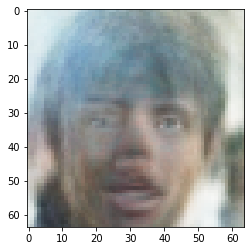

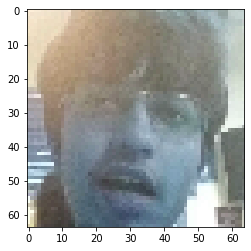

In [ ]:
from tensorflow.keras.models import load_model
recon=load_model("/content/drive/My Drive/face_reconstruct_v2.h5")
img=cv2.resize(cv2.imread("/content/drive/My Drive/me2.jpg",1),(64,64))/255.
plt.imshow(cv2.cvtColor(recon(img[np.newaxis],training=False).numpy().reshape(64,64,3), cv2.COLOR_RGB2BGR))
plt.show()
plt.imshow(img)

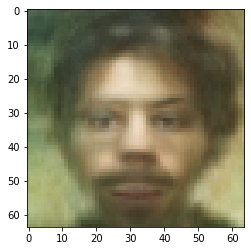

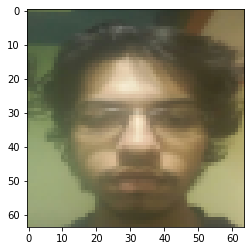

In [ ]:
from tensorflow.keras.models import load_model
recon=load_model("/content/drive/My Drive/face_reconstruct_v2.h5")
img=cv2.resize(cv2.imread("/content/drive/My Drive/me.jpg",1),(64,64),interpolation=cv2.INTER_AREA )
plt.imshow(cv2.cvtColor(recon(img[np.newaxis]/255.,training=False).numpy().reshape(64,64,3), cv2.COLOR_RGB2BGR))
plt.show()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

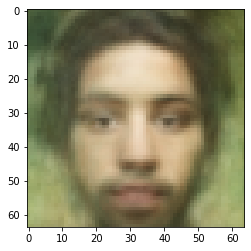

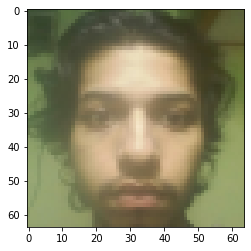

In [ ]:
img=cv2.resize(cv2.imread("/content/drive/My Drive/me4.jpg",1),(64,64),interpolation=cv2.INTER_AREA )
plt.imshow(cv2.cvtColor(recon(img[np.newaxis]/255.,training=False).numpy().reshape(64,64,3), cv2.COLOR_RGB2BGR))
plt.show()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))